In [5]:

from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

get_ipython().run_line_magic('matplotlib', 'inline')

Calculating Period...
Flux Maximum:  0.7822310891874247 Flux Minimum:  0.4762603901995125
N:1206
Calculating ...
index length:1206 index start:555 end index:1761
Observational Period:0.08788174487243622
[0.98550606, -0.7735364, 0.170206, 0.71303064, 0.7518328]
eccentricity1:0.7 eccentricity2:0.3
Retry again with initial eccentricities listed above.
Weight Flux:  220.95717437539824
Weight Resultant:  746.3268509615879
Frequency: 11.379+/-0.0000
Average Visual Magnitude:  1.5376+/-0.0000
Average Visual Magnitude:  1.9440+/-0.0000


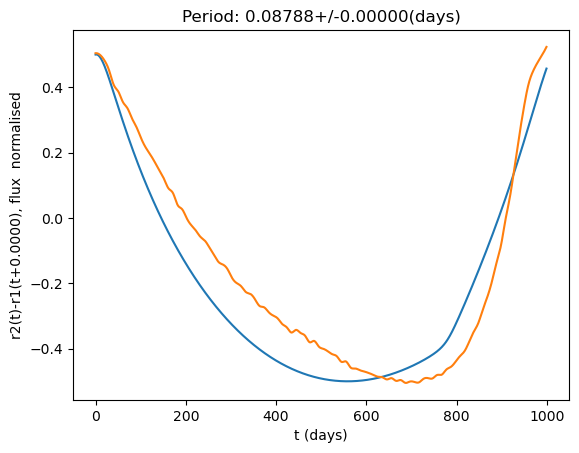

In [54]:

import tensorflow as tf
import pandas as pd
import numpy as np
import numpy as np
from scipy.signal import argrelextrema
from scipy.interpolate import CubicSpline
import random
import math
from scipy.interpolate import CubicSpline
import statistics
from statistics import mode


def extend_signal(signal,K):
   signal=np.array(signal)
   signal2=[]
   N=len(signal)
   
   for n in range(int(K*N)):
       signal2.append(signal[n%N])
   signal2=np.array(signal2)

   return signal2

def signal_weight(signal):
   X=0
   MinX=100000.0
   for x in signal:
       if x<MinX:
            MinX=x

   

   for x in signal:
       X=X+((x-MinX)*(x-MinX))
    
   return X


class EllipseEquation():

    t=[]
    dist=[]
    accel=[]
    vel=[]
    Theta=[]
    vel_x=[]
    dist_x=[]
    x_coords=[]
    y_coords=[]
    x_offset=0
    G=6.673e-11
    dt=0
    def __init__(self):
        return self
    def __init__(self,a,e,M):
        self.e=e
        self.a=a
        self.b=math.sqrt(a*a*(1-e*e))
        self.M=M
        self.P=2*math.pi*math.sqrt(self.a**3/(self.G*self.M))
    def calc_r(self,theta):
        return self.a*(1-self.e**2)/(1+self.e*math.cos(theta))
    def calc_v(self,r):
        return math.sqrt(self.G*self.M*(2/r-1/self.a))
    
    
    def calc(self,N,x_offset=0):
        #print ('Delta time in seconds:'+repr(dt))
        self.x_offset=x_offset
        self.t=[]
        self.dist=[]
        self.accel=[]
        self.Theta=[]
        self.vel=[]
        self.vel_x=[]
        self.dist_x=[]
        self.x_coords=[]
        self.y_coords=[]
        theta=0
        T=0
        X=0
        Dtheta=0
        D=0
        count=0
        theta_add=0
        self.dt=self.P/N
        while theta>=0 and theta<2*math.pi and count<10000:
            r=self.calc_r(theta)
            v=self.calc_v(r)
            
            x=r*math.cos(theta)+x_offset
            y=r*math.sin(theta)
            self.x_coords.append(x)
            self.y_coords.append(y)
            #print(x)
            d_theta=2*math.pi/N
            overflow_count=0
            
            while overflow_count<10:
                overflow_count+=1
                theta_dash=theta+d_theta
                r_dash=self.calc_r(theta_dash)
                v_dash=self.calc_v(r_dash)
                x_dash=r_dash*math.cos(theta_dash)+x_offset
                y_dash=r_dash*math.sin(theta_dash)
                
                d_dist=math.sqrt((x_dash-x)**2+(y_dash-y)**2)
                dt_dash=v/d_dist
                dt_ratio=dt_dash*self.dt
                #print(dt_ratio)
                if(dt_ratio<1.0001 and dt_ratio>=1):
                    break
                d_theta=d_theta*dt_ratio
            #print(d_theta)
            theta_dash=theta+d_theta
            r_dash=self.calc_r(theta_dash)
            v_dash=self.calc_v(r_dash)
            x_dash=r_dash*math.cos(theta_dash)+x_offset
            y_dash=r_dash*math.sin(theta_dash)
            
            D=math.sqrt((x)**2+(y)**2)
                
          
            
 
            self.t.append(T)
            self.dist.append(D)
            self.vel.append(v)
            self.accel.append((v_dash-v)/self.dt)
            self.Theta.append(theta)
            T=T+self.dt
            count+=1
            theta=theta_dash
            #print(theta)
            

        self.t=np.array(self.t)
        self.dist=np.array(self.dist)
        self.vel=np.array(self.vel)
        self.Theta=np.array(self.Theta)
        self.x_coords=np.array(self.x_coords)
        self.y_coords=np.array(self.y_coords)
        
        return count
class EllipticalDifferenceEquation(EllipseEquation):

        Mass=0
        semimajoraxis=0
        amplitude=1.0
        offset=0
        obs_amplitude=1.0
        obs_offset=0
        obs_period=0
        time=[]
        flux=[]
        resultant=[]
        dist=[]
        e1=0
        e2=0
        G=6.673e-11
        phase=0
        N=1000
        N_phase1=0
        N_phase2=0
        index0=0
        index1=0
        def __init__(self,time,flux,Mass,e1,e2):
            self.e1=e1
            self.e2=e2
            self.Mass=Mass
            self.time=np.array(time)
            self.flux=np.array(flux)
        def normalise(self,array_input):
            max_array=np.max(array_input)
            min_array=np.min(array_input)
            amplitude=max_array-min_array
            offset=(max_array+min_array)/(2*(amplitude))
            return array_input/amplitude-offset
        def apply_phase(self,array_input,phase):
            N=len(array_input)
            array_input=extend_signal(array_input,2)
            return array_input[range(int(phase*N),N+int(phase*N))]
        def calc_arrays(self,array1,array2,amplitude,phase):
            N=len(array1)
            amplitude=amplitude/N
            array_resultant=[]
            for i in range(N-1):
                j=i+phase
                if j>=N:
                    j=i+phase-N
                array_resultant.append(array1[i]-amplitude*array2[j])
            return np.array(array_resultant)
            
            
            
        def calc_weights(self,list_array,delta_phase):
            N=len(list_array[0])
        
            phase0=0
            amplitude=0
            min_args=[0,0,0]
            min_weight=9999999
            while phase0<N:
                phase1=int(0.1*N/2)
                while phase1<(int(N/2)-int(0.1*N/2)):
                    amplitude=int(N/2)
                    while amplitude<N:
                        array=self.calc_arrays(list_array[1],list_array[2],amplitude/N,phase1)
                        weight=signal_weight(self.calc_arrays(list_array[0],array,1.0,phase0))
                        #print(weight,phase1,phase0,amplitude)
                        if(weight<min_weight):
                            min_args=[phase1,phase0,amplitude]
                            min_weight=weight
                            #print(min_args)
                        amplitude+=delta_phase
                    phase1+=delta_phase
                phase0+=delta_phase
            print('.',end='')
                
                
            return min_args       
        def calc(self):
            print('Calculating ...')
            N=self.N
       
            print('index length:'+repr(N)+' index start:'+repr(self.index1)+' end index:'+repr(self.index0))
            
            self.flux=np.array(self.flux[range(self.index1,self.index0)])
            
            
           
            
            self.obs_period=self.time[self.index0]-self.time[self.index1]
            print('Observational Period:'+repr(self.obs_period))
            
            self.time=np.array(self.time[range(self.index1,self.index0)])
            self.time=self.time-self.time[0]
            
            
            spline_data=CubicSpline(self.time,self.flux)
            N=100 #data points
            self.time = np.linspace(0, self.obs_period, num=int(N)) #time base total 0.145668 days
            self.flux=spline_data(self.time)
            self.N=N
            
            
            self.flux=self.normalise(self.flux)
        
            self.semimajoraxis=math.pow((self.G*self.Mass)*(self.obs_period/(2*math.pi))**2,1/3)
            
        def calc_main(self,ARGS=[],E1=2,E2=7,deltaN=1): 
    
            N=100
      
            
            if(ARGS==[]):
                list_ellipse=[]
            
            
            
                min_weight=999999
                e1=0.1
        
            
                EE=EllipseEquation(self.semimajoraxis,e1,self.Mass)
            
                i=0
                while e1<0.89:
                    EE.e=e1
                    EE.calc(N)
                    list_ellipse.append(self.normalise(-EE.dist))
                    i+=1
                    e1+=0.1
                I=i      
                i=0
                while i<I:
                    j=0
                    while j<I:
                  
                        args=self.calc_weights([self.flux,list_ellipse[i],list_ellipse[j]],deltaN)
                        self.dist=self.calc_arrays(list_ellipse[i],list_ellipse[j],args[2],args[1])
                        self.dist=self.normalise(self.dist)
                        self.flux=self.calc_arrays(self.flux,self.dist,1.0,args[0])  
                        weight=signal_weight(self.flux-self.dist)
                        if(weight<min_weight):
                            min_weight=weight
                            E1=i
                            E2=j
                            ARGS=args
                        j+=1
                        print(' :'+repr(j),end='')
                    i+=1
                    print(' :'+repr(i),end='')
                self.dist=self.calc_arrays(list_ellipse[E1],list_ellipse[E2],ARGS[2],ARGS[1])
                self.dist=self.normalise(self.dist)
                self.flux=self.calc_arrays(self.flux,self.dist,1.0,ARGS[0])   
                print(ARGS)
            elif len(ARGS)==3:
                EE1=EllipseEquation(self.semimajoraxis,E1,self.Mass)
                EE2=EllipseEquation(self.semimajoraxis,E2,self.Mass)
                EE1.calc(N)
                EE2.calc(N)
                self.dist=self.calc_arrays(EE1.dist,EE2.dist,ARGS[2],ARGS[1])
                self.dist=self.normalise(self.dist)
                self.dist=self.normalise(self.dist)
                #self.flux=self.calc_arrays(self.flux,self.dist,1.0,ARGS[0])   
            elif len(ARGS)==2:
                EE1=EllipseEquation(self.semimajoraxis,E1,self.Mass)
                EE2=EllipseEquation(self.semimajoraxis,E2,self.Mass)
                EE1.calc(N+1)
                EE2.calc(N+1)
                args=self.calc_weights([self.flux,EE1.dist,EE2.dist],deltaN)
                self.dist=self.calc_arrays(EE1.dist,EE2.dist,args[2],args[1])
                self.dist=self.normalise(self.dist)
                self.flux=self.calc_arrays(self.flux,self.dist,1.0,args[0])  
                #weight=signal_weight(self.flux-self.dist)
                print(args)
            elif len(ARGS)==5:
                EE1=EllipseEquation(self.semimajoraxis,ARGS[3],self.Mass)
                EE2=EllipseEquation(self.semimajoraxis,ARGS[4],self.Mass)
                n=2
                while EE1.calc(N+n)>101:
                    n=n-1
                n=2
                while EE2.calc(N+n)>101:
                    n=n-1
                
                
                
                self.dist=self.calc_arrays(EE1.dist,EE2.dist,int(ARGS[2]*100),int(ARGS[1]*100))
                self.dist=self.normalise(self.dist)
                self.dist=self.normalise(self.dist)
                self.flux=self.calc_arrays(self.flux,self.dist,1.0,int(ARGS[0]*100))
                #weight=signal_weight(self.flux-self.dist)
                print(ARGS)
           
         

            
            
            
            
            
       
            
        
        def printout(self):
            spline_data1=CubicSpline(self.time[range(len(self.flux))],self.flux)
            spline_data2=CubicSpline(self.time[range(len(self.flux))],self.dist[range(len(self.flux))])
            N=1000 #data points
 
            self.time = np.linspace(0, self.obs_period, num=int(N)) #time base total 0.145668 days
            
            self.flux=spline_data1(self.time)
            self.dist=spline_data2(self.time)
            self.N=N
            print('eccentricity1:'+repr(self.e1)+' eccentricity2:'+repr(self.e2))
            print('Retry again with initial eccentricities listed above.')
                      
            #print('Phase 1: '+repr(M1+20)+' value: '+repr(phase_weights[M1]))
            #print('Phase 2: '+repr(M2)+' value: '+repr(weights[M2]))
            weight_flux=signal_weight(self.flux)
            weight_resultant=signal_weight(self.flux-self.dist)
            print('Weight Flux:  '+repr(weight_flux))
            print('Weight Resultant:  '+repr(weight_resultant))
            ratio_weight=weight_resultant/weight_flux
            if(ratio_weight>1):
                period_error=0
            else:
                period_error=0.5*self.obs_period*ratio_weight
                
            freq_error=-1/(self.obs_period+period_error)+1/(self.obs_period-period_error)
            print('Frequency: '+format(1/self.obs_period,'0.3f')+'+/-'+format(freq_error,'0.4f'))
            mag_error=-2.81*math.log10(self.obs_period+period_error)+2.81*math.log10(self.obs_period-period_error)
            print('Average Visual Magnitude: ',format(-2.81*math.log10(self.obs_period)-1.43,'0.4f')+'+/-'+format(mag_error,'0.4f'))
            mag_error=-3.725*math.log10(self.obs_period+period_error)+3.725*math.log10(self.obs_period-period_error)
            print('Average Visual Magnitude: ',format(-3.725*math.log10(self.obs_period)-1.99,'0.4f')+'+/-'+format(mag_error,'0.4f'))
            
            self.resultant=self.flux-self.dist
            plt.plot(-self.dist)
            plt.plot(self.flux)
            plt.xlabel('t (days)')
            plt.ylabel('r2(t)-r1(t+'+format(self.N_phase1/self.N,'.4f')+'), flux  normalised')
            plt.title('Period: '+format(self.obs_period,'0.5f')+'+/-'+format(period_error,'.5f')+'(days)')
            plt.show()
            

        
        def optimise_e(self,e=1,count_max=5,phase_max1=0.1,phase_max2=0.05,phase_min=0.02,delta_phase1=1,delta_phase2=1):
            N=self.N
            if (e==1):
                e1=self.e1
            else:
                e1=self.e2
            print('Calculating Phase,Eccentricity...')
            list_resultant_weight=[]
            counter_e1=0
            delta_e1=0.1
            while counter_e1<count_max:
                
                calc_phase([self.ellipse2.dist,self.ellipse1.dist,self.flux],0.5,10)
                
                

                self.dist=dist5
                weight_flux=signal_weight(self.flux)
                weight_resultant=signal_weight(dist5-self.flux)
                list_resultant_weight.append(weight_resultant)
                if(counter_e1>0):
                    difference_weight_resultant=list_resultant_weight[counter_e1]-list_resultant_weight[counter_e1-1]
                    if(abs(difference_weight_resultant)>1):
                        if(difference_weight_resultant<0):
                            delta_e1=-0.05/abs(difference_weight_resultant)
                        else:
                            delta_e1=0.05/abs(difference_weight_resultant)
                    else:
                        delta_e1=difference_weight_resultant*delta_e1
                    #print('Delta e1: '+repr(delta_e1))
                if(abs(delta_e1)<0.0001):
                    break
                e1=e1+delta_e1
                if(e==1):
                    self.ellipse1.e=e1
                else:
                    self.ellipse2.e=e1
                n=N+2
              
                if(e==1):
                    N2=self.ellipse1.calc(n)
                else:
                    N2=self.ellipse2.calc(n)
                while N!=N2:
                    n=n-1
                    if(e==1):
                        N2=self.ellipse1.calc(n)
                    else:
                        N2=self.ellipse2.calc(n)

                counter_e1+=1
                print(counter_e1)
            if(e==1):
                self.e1=e1
            else:
                self.e2=e1
            self.N_phase1=M1
            self.N_phase2=M2
            
            
            
        def calc_period(self):
             ##################################### PERIOD CALCULATION #########################################
            #use adaptive smoothing to find optimal maxima for period calculation
            use_maxima=True #False untested
            print('Calculating Period...')
            Smooth_factor=20
         
            N_list=[]
            Index0_list=[]
            Index1_list=[]
            N_fluxmax=len(self.flux)
            if(N_fluxmax>1000): # cut short due to errors with np.max
                 N_fluxmax=1000
            #to avoid local maxima choose maxima with flux above %90 maximum
            fluxmax=0.95*np.max(self.flux[range(N_fluxmax)])
            fluxmin=0.95*np.min(self.flux[range(N_fluxmax)])
            print('Flux Maximum:  '+repr(fluxmax)+' Flux Minimum:  '+repr(fluxmin))
            while Smooth_factor<60:
                test_flux=np.convolve(self.flux,np.ones(Smooth_factor)/Smooth_factor,mode='same')
                maxima=argrelextrema(test_flux,np.greater)
                minima=argrelextrema(test_flux,np.less)
                maxima=maxima[0]
                minima=minima[0]
                temp_maxima=[]
                for maxima_index in maxima:
                    if(self.flux[maxima_index]>fluxmax):
                        temp_maxima.append(maxima_index)
                maxima=temp_maxima
                temp_minima=[]
                for minima_index in maxima:
                    if(self.flux[minima_index]<fluxmin):
                        temp_minima.append(minima_index)
                minima=temp_minima
                #print(maxima)
                i=1
                N=0
                while N<1000: #period cutoff 
                    if use_maxima:
                        if(i+1>len(maxima)):
                            break
                        N=maxima[i]-maxima[i-1]
                    else:
                        if(i+1>len(minima)):
                            break
                        N=minima[i]-minima[i-1]
                    i=i+1
                i=i-1
                if(N>10): # use values that represent a proper period
                    N_list.append(N)
                    if use_maxima:
                        Index0_list.append(maxima[i])
                        Index1_list.append(maxima[i-1])
                    else:
                        Index0_list.append(minima[i])
                        Index1_list.append(minima[i-1])
                        
                #print(N)
                Smooth_factor=Smooth_factor+1
                
            
            #choose most frequent from (N_list)
            self.N=mode(N_list)
            
            print('N:'+repr(self.N))
            
            #search N_list for index of N
            i=0
            for j in range(len(N_list)):
                if(N_list[j]==self.N):
                    i=j
                    break
            self.index0=Index0_list[i]
            self.index1=Index1_list[i]
            #####################################################################################################
            
def shuffle(inputs_train,labels_train,N_counter):
    counter=0
    while counter<N_counter:
        index1=random.randint(0,len(inputs_train)-1)
        index2=random.randint(0,len(inputs_train)-1)
        temp1=inputs_train[index1]
        temp2=labels_train[index1]
        labels_train[index1]=labels_train[index2]
        labels_train[index2]=temp2
        inputs_train[index1]=inputs_train[index2]
        inputs_train[index2]=temp1
        counter+=1
        #print(inputs_train,labels_train)
    return (inputs_train,labels_train)
    
rel_flux=(0.516874,0.514718,0.513875,0.51701,0.515947,0.516506,0.514698,0.514998,0.51023,0.507271,0.509727,0.511362,0.506488,0.508958,0.507097,0.506385,0.502653,0.508093,0.503255,0.504292,0.506062,0.501479,0.504612,0.503892,0.509819,0.502666,0.50247,0.506035,0.506205,0.504486,0.505797,0.506178,0.510974,0.508446,0.508027,0.506151,0.514618,0.516266,0.517662,0.522371,0.524497,0.526994,0.530796,0.536497,0.544171,0.549154,0.551763,0.55893,0.570134,0.575073,0.583214,0.596239,0.603371,0.61613,0.627472,0.644398,0.652329,0.671484,0.691639,0.702505,0.723772,0.743772,0.760631,0.775118,0.785617,0.79526,0.803752,0.794038,0.786258,0.78557,0.777623,0.774241,0.769259,0.762497,0.757905,0.751677,0.742528,0.74069,0.733236,0.728572,0.724491,0.719929,0.713713,0.709665,0.703484,0.701474,0.692684,0.690999,0.684574,0.677643,0.675762,0.670914,0.665341,0.662756,0.656312,0.654239,0.64872,0.647028,0.644872,0.640277,0.636528,0.632404,0.626704,0.622936,0.623371,0.618118,0.616468,0.609824,0.606578,0.603021,0.602043,0.598819,0.595745,0.591926,0.592143,0.587627,0.586611,0.580896,0.579149,0.57916,0.575455,0.572138,0.571212,0.569107,0.567314,0.56236,0.559392,0.560168,0.555153,0.559972,0.554559,0.554885,0.551798,0.551857,0.546404,0.546068,0.546875,0.542806,0.540206,0.539358,0.5379,0.53581,0.534171,0.532926,0.530805,0.526911,0.528021,0.525736,0.521182,0.523219,0.519413,0.518268,0.519494,0.517206,0.516313,0.515425,0.514182,0.513064,0.512183,0.512074,0.509471,0.510413,0.511378,0.508993,0.508499,0.509499,0.507778,0.506582,0.507644,0.506492,0.508728,0.506722,0.508668,0.511519,0.510983,0.50951,0.511776,0.513629,0.515124,0.51429,0.518482,0.519538,0.522113,0.524569,0.529436,0.532123,0.536144,0.537676,0.545072,0.551342,0.557408,0.562603,0.568011,0.579297,0.586273,0.595202,0.60494,0.617419,0.625935,0.638816,0.656777,0.668723,0.684399,0.702941,0.721203,0.740341,0.757633,0.774475,0.788345,0.801681,0.8066,0.813014,0.816262,0.821714,0.821885,0.823638,0.818231,0.817136,0.812044,0.811869,0.809314,0.802038,0.797923,0.791057,0.7838,0.782822,0.775374,0.771899,0.762528,0.759973,0.754587,0.747702,0.742875,0.73873,0.73184,0.726124,0.721643,0.715755,0.71217,0.706259,0.701883,0.69765,0.692345,0.688974,0.683167,0.678736)
time_base=(0,0.000569,0.00114,0.001709,0.002279,0.002849,0.003418,0.003989,0.004559,0.005128,0.005698,0.006268,0.006837,0.007407,0.007977,0.008546,0.009116,0.009686,0.010255,0.010825,0.011395,0.011964,0.012534,0.013104,0.013673,0.014242,0.014812,0.015381,0.015951,0.016521,0.01709,0.01766,0.01823,0.018799,0.019369,0.019938,0.020508,0.021077,0.021647,0.022217,0.022786,0.023356,0.023925,0.024495,0.025064,0.025634,0.026204,0.026773,0.027343,0.027912,0.028482,0.029052,0.029621,0.030191,0.03076,0.03133,0.0319,0.032469,0.033039,0.033608,0.034178,0.034747,0.035317,0.035886,0.036456,0.037026,0.037595,0.0439,0.04447,0.045039,0.045608,0.046178,0.046747,0.047317,0.047886,0.048456,0.049026,0.049595,0.050165,0.050734,0.051304,0.051873,0.052443,0.053013,0.053583,0.054152,0.054722,0.055291,0.055861,0.05643,0.057,0.057569,0.058139,0.058708,0.059278,0.059847,0.060417,0.060987,0.061556,0.062126,0.062696,0.063265,0.063835,0.064404,0.064974,0.065543,0.066113,0.066682,0.067252,0.067821,0.068391,0.068961,0.06953,0.0701,0.070669,0.071239,0.071809,0.072379,0.072949,0.073518,0.074088,0.074657,0.075227,0.075797,0.076366,0.076935,0.077505,0.078075,0.078644,0.079214,0.079783,0.080353,0.080923,0.081492,0.082062,0.082632,0.083201,0.083771,0.08434,0.08491,0.085479,0.086049,0.086618,0.087188,0.087757,0.088327,0.088897,0.089466,0.090036,0.090605,0.091175,0.091744,0.092314,0.092884,0.093453,0.094023,0.094593,0.095162,0.095732,0.096302,0.096872,0.097441,0.09801,0.09858,0.099149,0.099719,0.100289,0.101241,0.10181,0.10238,0.102949,0.103519,0.104089,0.104658,0.105228,0.105797,0.106367,0.106937,0.107506,0.108075,0.108645,0.109215,0.109784,0.110354,0.110923,0.111493,0.112062,0.112632,0.113201,0.113771,0.114341,0.11491,0.11548,0.116049,0.116619,0.117189,0.117758,0.118328,0.118897,0.119467,0.120036,0.120606,0.121176,0.121745,0.122315,0.122885,0.123454,0.124024,0.124593,0.125163,0.125732,0.126302,0.126871,0.127441,0.128011,0.12858,0.12915,0.129719,0.130289,0.130858,0.131428,0.131998,0.132567,0.133137,0.133706,0.134276,0.134845,0.135415,0.135984,0.136554,0.137124,0.137693,0.138263,0.138832,0.139402,0.139972,0.140541,0.141111,0.141681,0.14225,0.14282,0.14339,0.143959,0.144529,0.145098,0.145668)

spline_data=CubicSpline(time_base,rel_flux)
O=2000 #data points
t = np.linspace(0, 0.145668, num=int(O)) #time base total 0.145668 days
signal=spline_data(t)
    
                
M=1.9891E30 #Mass in kg
e1=0.70 #eccentricity of ellipse 1
e2=0.30 #eccentricity of ellipse 2

EDE_main=EllipticalDifferenceEquation(t,signal,M,e1,e2)
EDE_main.calc_period()
EDE_main.calc()
EDE_main.calc_main([0.98550606 ,0.7735364  ,0.170206  , 0.71303064, 0.7518328 ])




EDE_main.printout()

In [48]:
print("Loading light_curve_model.keras")
model = tf.keras.models.load_model("./light_curve_model.keras")
input_dist=EDE_main.flux[range(99)]
input_dist=tf.reshape(input_dist,(1,99))

pred = model.predict(input_dist) 
print(pred[0])

Loading light_curve_model.keras
1/1 [==============================] - 0s 139ms/step
[0.98550606 0.7735364  0.170206   0.71303064 0.7518328 ]
